# Lambda School Data Science - Quantile Regression

Regressing towards the median - or any quantile - as a way to mitigate outliers and control risk.

## Lecture

Let's look at data that has a bit of a skew to it:

http://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [0]:
import pandas as pd
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                 '00381/PRSA_data_2010.1.1-2014.12.31.csv')

In [0]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [0]:
df.describe()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [0]:
df['pm2.5'].plot.hist();

In [0]:
# How does linear regression handle it?
from sklearn.linear_model import LinearRegression

# Let's drop NAs and limit to numeric values
df = df._get_numeric_data().dropna()
X = df.drop('pm2.5', axis='columns')
y = df['pm2.5']

linear_reg = LinearRegression().fit(X, y)
linear_reg.score(X, y)

0.25900063996588474

In [0]:
# Not bad - but what if we wanted to model the distribution more conservatively?
# Let's try quantile
#!pip install statsmodels
import statsmodels.formula.api as smf

# Different jargon/API in StatsModel documentation
# "endogenous" response var is dependent (y), it is "inside"
# "exogenous" variables are independent (X), it is "outside"
# Bonus points - talk about "exogenous shocks" and you're a bona fide economist

# ~ style formulas look like what R uses
# y ~ x1 + x2 + ...
# Also, these formulas break with . in variable name, so lets change that
df = df.rename(index=str, columns={'pm2.5': 'pm25'})

# Now let's construct the formula string using all columns
quant_formula = 'pm25 ~ ' + ' + '.join(df.drop('pm25', axis='columns').columns)
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.5)
quant_reg.summary()  # "summary" is another very R-thing

    100% |████████████████████████████████| 7.4MB 8.5MB/s eta 0:00:01
    100% |████████████████████████████████| 235kB 35.8MB/s ta 0:00:01
pm25 ~ No + year + month + day + hour + DEWP + TEMP + PRES + Iws + Is + Ir


/home/britton/.conda/envs/basicNLP/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                   pm25   Pseudo R-squared:               0.1600
Model:                       QuantReg   Bandwidth:                       8.276
Method:                 Least Squares   Sparsity:                        133.8
Date:                Wed, 23 Jan 2019   No. Observations:                41757
Time:                        14:28:59   Df Residuals:                    41745
                                        Df Model:                           11
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0004   1.67e-05     22.881      0.000       0.000       0.000
No           3.63e-07   2.67e-05      0.014      0.989    -5.2e-05    5.27e-05
year           0.8830      0.031     28.631      0.000       0.823       0.943
month         -1.4110      0.103    -13.749      0.000      -1.612      -1.210
day            0.4461      0.037     11.951      0.000       0.373       0.519
hour           1.2810      0.050     25.779      0.000       1.184       1.378
DEWP           3.6362      0.047     77.315      0.000       3.544       3.728
TEMP          -4.7103      0.060    -78.779      0.000      -4.828      -4.593
PRES          -1.6265      0.061    -26.760      0.000      -1.746      -1.507
Iws           -0.1541      0.007    -21.786      0.000      -0.168      -0.140
Is            -1.6322      0.425     -3.838      0.000      -2.466      -0.799
Ir            -5.3946      0.234    -23.034      0.000      -5.854      -4.936
==============================================================================

The condition number is large, 3.26e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

That fit to the median (q=0.5), also called "Least Absolute Deviation." The pseudo-R^2 isn't really directly comparable to the R^2 from linear regression, but it clearly isn't dramatically improved. Can we make it better?

In [0]:
help(quant_mod.fit)

Help on method fit in module statsmodels.regression.quantile_regression:

fit(q=0.5, vcov='robust', kernel='epa', bandwidth='hsheather', max_iter=1000, p_tol=1e-06, **kwargs) method of statsmodels.regression.quantile_regression.QuantReg instance
    Solve by Iterative Weighted Least Squares
    
    Parameters
    ----------
    q : float
        Quantile must be between 0 and 1
    vcov : string, method used to calculate the variance-covariance matrix
        of the parameters. Default is ``robust``:
    
        - robust : heteroskedasticity robust standard errors (as suggested
          in Greene 6th edition)
        - iid : iid errors (as in Stata 12)
    
    kernel : string, kernel to use in the kernel density estimation for the
        asymptotic covariance matrix:
    
        - epa: Epanechnikov
        - cos: Cosine
        - gau: Gaussian
        - par: Parzene
    
    bandwidth: string, Bandwidth selection method in kernel density
        estimation for asymptotic covarian

In [0]:
quantiles = (.05, .96, .1)

for quantile in quantiles:
  print(quant_mod.fit(q=quantile).summary())

                         QuantReg Regression Results                          
Dep. Variable:                   pm25   Pseudo R-squared:              0.04130
Model:                       QuantReg   Bandwidth:                       8.908
Method:                 Least Squares   Sparsity:                        120.7
Date:                Wed, 23 Jan 2019   No. Observations:                41757
Time:                        14:31:09   Df Residuals:                    41745
                                        Df Model:                           11
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.072e-05    6.4e-06      4.804      0.000    1.82e-05    4.33e-05
No         -6.994e-05   9.59e-06     -7.292      0.000   -8.87e-05   -5.11e-05
year           0.0998      0.012      8.275      0.000       0.076       0.123
month         -0.4536      0.034    -13.419      0.0

"Strong multicollinearity", eh? In other words - maybe we shouldn't throw every variable in our formula. Let's hand-craft a smaller one, picking the features with the largest magnitude t-statistics for their coefficients. Let's also search for more quantile cutoffs to see what's most effective.

In [0]:
quant_formula = 'pm25 ~ DEWP + TEMP + Ir + hour + Iws'
quant_mod = smf.quantreg(quant_formula, data=df)
for quantile in range(50, 100):
  quantile /= 100
  quant_reg = quant_mod.fit(q=quantile)
  print((quantile, quant_reg.prsquared))

(0.5, 0.14478793360200437)
(0.51, 0.14530464991077086)
(0.52, 0.14579844562510003)
(0.53, 0.14627848333343285)
(0.54, 0.1467640446508116)
(0.55, 0.14733094759544685)
(0.56, 0.14787821797666834)
(0.57, 0.14840185621292323)
(0.58, 0.14892138273948985)
(0.59, 0.14946793972069583)


/home/britton/.conda/envs/basicNLP/lib/python3.6/site-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


(0.6, 0.15004508362535396)
(0.61, 0.15066665496418408)
(0.62, 0.1513155052092907)
(0.63, 0.15201598245712833)
(0.64, 0.15281563218060867)
(0.65, 0.1536013388355193)
(0.66, 0.15440046026575627)
(0.67, 0.1552125175853546)
(0.68, 0.156076156789546)
(0.69, 0.15692695615283503)
(0.7, 0.1577663389046534)
(0.71, 0.1586528621299954)
(0.72, 0.15961363441230658)
(0.73, 0.16062991119787984)
(0.74, 0.161715120189729)
(0.75, 0.16280951619864648)
(0.76, 0.1639425939348157)
(0.77, 0.1651745144874267)
(0.78, 0.16644234437130068)
(0.79, 0.16770815353096247)


/home/britton/.conda/envs/basicNLP/lib/python3.6/site-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


(0.8, 0.1690422735295043)
(0.81, 0.17037126968954486)
(0.82, 0.1719559312233302)
(0.83, 0.1738389260638118)
(0.84, 0.1759991842632862)
(0.85, 0.17817588507322768)
(0.86, 0.1804743470688509)
(0.87, 0.182748429636438)
(0.88, 0.18507489278263434)
(0.89, 0.18767194363815876)
(0.9, 0.18998714640826875)
(0.91, 0.19205778885864289)
(0.92, 0.19409258046839606)
(0.93, 0.1960928580149024)
(0.94, 0.19907185856543497)
(0.95, 0.20306510227278907)
(0.96, 0.2082885456209963)
(0.97, 0.21268428179849552)
(0.98, 0.21668870123970496)
(0.99, 0.2174294131820318)


In [0]:
# Okay, this data seems *extremely* skewed
# Let's trying logging
import numpy as np

df['pm25'] = np.log(1 + df['pm25'])
quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.25)
quant_reg.summary()  # "summary" is another very R-thing

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                   pm25   Pseudo R-squared:               0.2292
Model:                       QuantReg   Bandwidth:                      0.1012
Method:                 Least Squares   Sparsity:                        2.806
Date:                Wed, 23 Jan 2019   No. Observations:                41757
Time:                        14:34:02   Df Residuals:                    41751
                                        Df Model:                            5
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.2445      0.013    318.122      0.000       4.218       4.271
DEWP           0.0722      0.001     96.789      0.000       0.071       0.074
TEMP          -0.0701      0.001    -83.635      0.000      -0.072      -0.069
Ir            -0.1079      0.004    -29.400      0.000      -0.115      -0.101
hour           0.0215      0.001     23.202      0.000       0.020       0.023
Iws           -0.0040      0.000    -36.699      0.000      -0.004      -0.004
==============================================================================
"""

Overall - in this case, quantile regression is not *necessarily* superior to linear regression. But it does give us extra flexibility and another thing to tune - what the center of what we're actually fitting in the dependent variable.

The basic case of `q=0.5` (the median) minimizes the absolute value of residuals, while OLS minimizes the squared value. By selecting `q=0.25`, we're targeting a lower quantile and are effectively saying that we only want to over-estimate at most 25% of the time - we're being *risk averse*.

Depending on the data you're looking at, and the cost of making a false positive versus a false negative, this sort of flexibility can be extremely useful.

Live - let's consider another dataset! Specifically, "SkillCraft" (data on competitive StarCraft players): http://archive.ics.uci.edu/ml/datasets/SkillCraft1+Master+Table+Dataset

In [0]:
# TODO Live!
# Hint - we may only care about the *top* quantiles here
# Another hint - there are missing values, but Pandas won't see them right away

## Assignment - birth weight data

Birth weight is a situation where, while the data itself is actually fairly normal and symmetric, our main goal is actually *not* to model mean weight (via OLS), but rather to identify mothers at risk of having children below a certain "at-risk" threshold weight.

Quantile regression gives us just the tool we need. For the data we are using, see: http://people.reed.edu/~jones/141/BirthWgt.html

    bwt: baby's weight in ounces at birth
    gestation: duration of pregnancy in days
    parity: parity indicator (first born = 1, later birth = 0)
    age: mother's age in years
    height: mother's height in inches
    weight: mother's weight in pounds (during pregnancy)
    smoke: indicator for whether mother smokes (1=yes, 0=no) 
    
Use this data and `statsmodels` to fit a quantile regression, predicting `bwt` (birth weight) as a function of the other covariates. First, identify an appropriate `q` (quantile) to target a cutoff of 90 ounces - babies above that birth weight are generally healthy/safe, babies below are at-risk.

Then, fit and iterate your model. Be creative! You may want to engineer features. Hint - mother's age likely is not simply linear in its impact, and the other features may interact as well.

At the end, create at least *2* tables and *1* visualization to summarize your best model. Then (in writing) answer the following questions:

- What characteristics of a mother indicate the highest likelihood of an at-risk (low weight) baby?
- What can expectant mothers be told to help mitigate this risk?

Note that second question is not exactly a data science question - and that's okay! You're not expected to be a medical expert, but it is a good exercise to do a little bit of digging into a particular domain and offer informal but informed opinions.

In [0]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import norm

#!wget https://github.com/MaxGhenis/random/raw/master/Roboto-Regular.ttf -P /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf
mpl.font_manager._rebuild()

In [0]:
sns.set_style('white')
DPI = 175
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 4.4, 3.0  # Default.
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

In [78]:
bwt_df.shape

(1174, 7)

## Import Data

In [79]:
bwt_df = pd.read_csv('http://people.reed.edu/~jones/141/Bwt.dat')
bwt_df.head()

,bwt,gestation,parity,age,height,weight,smoke
0,120,284,0,27,62,100,0
1,113,282,0,33,64,135,0
2,128,279,0,28,64,115,1
3,108,282,0,23,67,125,1
4,136,286,0,25,62,93,0


In [80]:
bwt_df.describe()

,bwt,gestation,parity,age,height,weight,smoke
count,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000
mean,119.462521,279.101363,0.262351,27.228279,64.049404,128.478705,0.390971
std,18.328671,16.010305,0.440100,5.817839,2.526102,20.734282,0.488176
min,55.000000,148.000000,0.000000,15.000000,53.000000,87.000000,0.000000
25%,108.000000,272.000000,0.000000,23.000000,62.000000,114.250000,0.000000
50%,120.000000,280.000000,0.000000,26.000000,64.000000,125.000000,0.000000
75%,131.000000,288.000000,1.000000,31.000000,66.000000,139.000000,1.000000
max,176.000000,353.000000,1.000000,45.000000,72.000000,250.000000,1.000000


In [81]:
bwt_df.head()

,bwt,gestation,parity,age,height,weight,smoke
0,120,284,0,27,62,100,0
1,113,282,0,33,64,135,0
2,128,279,0,28,64,115,1
3,108,282,0,23,67,125,1
4,136,286,0,25,62,93,0


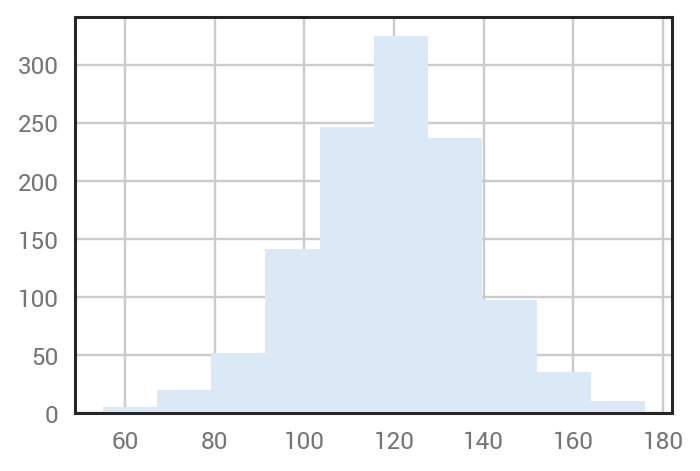

In [82]:
bwt_df.bwt.hist()

In [93]:
# Define my X & Y
y=bwt_df["bwt"]
X=bwt_df.drop(columns=['bwt'])

# Going to try a standard scaling my X to normalize.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit_transform(bwt_df)
scaled_df = pd.DataFrame(scaler)
X_scaled = scaled_df.iloc[:,1]
y_scaled = scaled_df[0]
print(X_scaled.shape)
print(y_scaled.shape)

# Here is where I split the model into test/train sets. 
from sklearn.model_selection import train_test_split
X_train, X_test, train_labels, test_labels = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
X_train_denorm, X_test_denorm, y_train_denorm, y_test_denorm = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Format Data for Statsmodels
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

(1174,)
(1174,)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [97]:
METHODS = ['OLS', 'QuantReg']

QUANTILES = [0.1, 0.3, 0.5, 0.7, 0.9]
# QUANTILES.reverse()  # Test out to see if we're getting different results.

quantiles_legend = [str(int(q * 100)) + 'th percentile' for q in QUANTILES]

preds = np.array([(method, q, feature) 
                  for method in METHODS 
                  for q in QUANTILES
                  for feature in x_test])
preds = pd.DataFrame(preds)
preds.columns = ['method', 'q', 'x']
preds = preds.apply(lambda x: pd.to_numeric(x, errors='ignore'))

preds['label'] = np.resize(test_labels, preds.shape[0])

print(preds)

   method    q  x     label
0     OLS  0.1  1 -0.188993
1     OLS  0.1  2 -2.808957
2     OLS  0.1  3 -0.134411
3     OLS  0.1  4 -0.243576
4     OLS  0.3  1  0.247667
5     OLS  0.3  2  0.029337
6     OLS  0.3  3  2.376388
7     OLS  0.3  4 -1.771888
8     OLS  0.5  1  0.247667
9     OLS  0.5  2 -0.407324
10    OLS  0.5  3 -0.188993
11    OLS  0.5  4 -0.079828
12    OLS  0.7  1  1.175571
13    OLS  0.7  2 -0.953149
14    OLS  0.7  3  0.629745
15    OLS  0.7  4  0.520580
16    OLS  0.9  1 -0.898567
17    OLS  0.9  2  1.230154
18    OLS  0.9  3 -0.516489
19    OLS  0.9  4  2.158058


In [0]:
# sns.set_palette(sns.color_palette('Blues', len(QUANTILES)))
sns.set_palette(sns.color_palette('Blues'))
# Set dots to a light gray
dot_color = sns.color_palette('coolwarm', 4)[1]

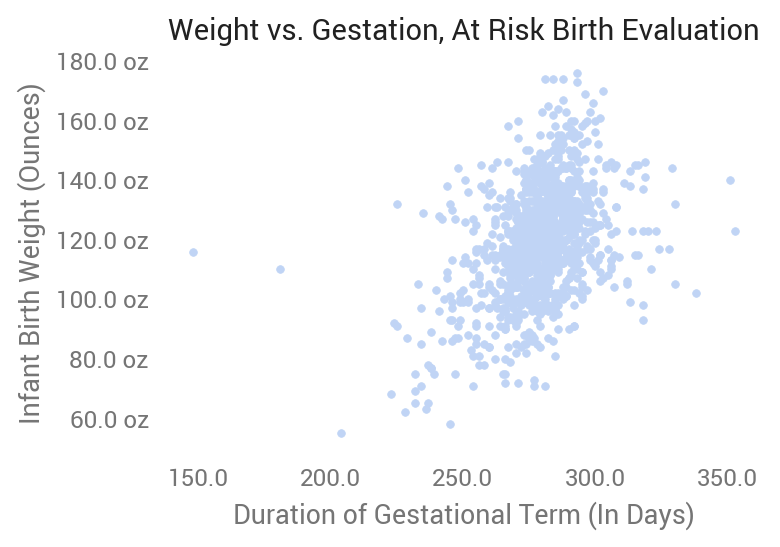

In [90]:
from matplotlib.ticker import FuncFormatter

ax = plt.scatter(x=bwt_df.gestation, y=bwt_df.bwt, color=dot_color, s= 10)
plt.title('Weight vs. Gestation, At Risk Birth Evaluation', loc='center')
sns.despine(left=True, bottom=True)
ax.axes.xaxis.set_major_formatter(FuncFormatter(
    lambda x, _: '{}'.format(x)))
ax.axes.yaxis.set_major_formatter(FuncFormatter(
    lambda y, _: '{} oz'.format(y)))
plt.xlabel('Duration of Gestational Term (In Days)')
plt.ylabel('Infant Birth Weight (Ounces)')
plt.show()

In [69]:
quant_formula = 'bwt ~ gestation + smoke + height + weight + parity'
# Try all of them. 
quant_mod = smf.quantreg(quant_formula, data=bwt_df)
#for quantile in range(50, 100):
#  quantile /= 100
#  quant_reg = quant_mod.fit(q=quantile)
#  print((quantile, quant_reg.prsquared))

# Try a single one
#df['pm25'] = np.log(1 + df['pm25'])
quant_mod = smf.quantreg(quant_formula, data=bwt_df)
quant_reg = quant_mod.fit(q=.9)
quant_reg.summary()  #

###########################
#Bwt <- read.csv("http://www.reed.edu/~jones/141/Bwt.dat")
#summary(Bwt)

#Bwt.lm <- lm(bwt ~ gestation + smoke + height + weight + parity,data=Bwt)
#summary(Bwt.lm)
#plot(fitted(Bwt.lm),residuals(Bwt.lm),pch=19,
#     col=ifelse(Bwt$smoke==1,"red","blue"))
#abline(h=c(-2,0,2)*15.8,lty=2,lwd=2,col="darkgreen")

#qqnorm(residuals(Bwt.lm),pch=18,col="blue")
#qqline(residuals(Bwt.lm),lwd=2,col="red")

#plot(hatvalues(Bwt.lm),cooks.distance(Bwt.lm),pch=18,col="blue")
#identify(hatvalues(Bwt.lm),cooks.distance(Bwt.lm))

#Bwt[239,]

#dfbetas(Bwt.lm)[239,]
#coefficients(Bwt.lm)

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:               0.1154
Model:                       QuantReg   Bandwidth:                       5.806
Method:                 Least Squares   Sparsity:                        87.09
Date:                Fri, 25 Jan 2019   No. Observations:                 1174
Time:                        09:17:21   Df Residuals:                     1168
                                        Df Model:                            5
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -61.3532     27.784     -2.208      0.027    -115.866      -6.841
gestation      0.3719      0.062      6.036      0.000       0.251       0.493
smoke         -8.6142      1.609     -5.354      0.000     -11.771      -5.458
height         1.3181      0.385      3.421      0.001       0.562       2.074
weight         0.1353      0.040      3.394      0.001       0.057       0.214
parity        -6.7382      1.773     -3.800      0.000     -10.217      -3.259
==============================================================================

The condition number is large, 9.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [96]:
# OLS https://stackoverflow.com/questions/17559408/confidence-and-prediction-intervals-with-statsmodels
ols = sm.OLS(train_labels, X_train).fit()
def ols_quantile(m, X, q):
  # m: OLS model.
  # X: X matrix.
  # q: Quantile.
  #
  # Set alpha based on q. Vectorized for different values of q.
  mean_pred = m.predict(X)
  se = np.sqrt(m.scale)
  return mean_pred + norm.ppf(q) * se

preds.loc[preds.method == 'OLS', 'pred'a] = np.concatenate(
    [ols_quantile(ols, X_test, q) for q in QUANTILES])

ValueError: ignored

## Resources and stretch goals

Resources:
- [statsmodels QuantReg example](http://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html)
- [How Shopify used Quantile Regression in modeling risk](https://medium.com/data-shopify/how-shopify-capital-uses-quantile-regression-to-help-merchants-succeed-10ee1b36b17d)

Stretch goals:
- Find a dataset where you think quantile regression may be appropriate, and try both it and linear regression - compare/contrast their strengths/weaknesses, and write a summary for which you think is better for the situation and why
- Check out [deep quantile regression](https://www.kdnuggets.com/2018/07/deep-quantile-regression.html), an approach that uses a custom quantile loss function and Keras to train a quantile model